# ***Emotion Detection - Using Facial Expressions***
### ***Code by @Om***

In [69]:
from google.colab import files
files.upload()

{}

In [70]:
# Code for importing dataset from Kaggle using the Kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [71]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

emotion-detection-fer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [72]:
# Import all the required libraries 

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pathlib
import zipfile
from zipfile import ZipFile
import os
import PIL
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
file_name = "emotion-detection.zip"

# Create new folder to extract files 
os.mkdir('Emotion-detection-dataset')

with ZipFile(file_name,'r') as zip:
  # Extract files to created folder
  zip.extractall('Emotion-detection-dataset')
  print("Files extracted!")

In [74]:
path = "/content/Emotion-detection-dataset"
print("Dataset Folder Path- ",path);

Dataset Folder Path-  /content/Emotion-detection-dataset


### **Creating training & validation datasets (TF Datasets)**

In [75]:
# Create training & validation directories
train_dir = os.path.join(path,"train")
validation_dir = os.path.join(path,'test')

batch_size = 128
img_size = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size = batch_size,
                                             image_size = img_size)

validation_dataset = image_dataset_from_directory(validation_dir,  
                                                  shuffle=True,
                                                  batch_size = batch_size,
                                                  image_size = img_size)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


## **Analyzing the dataset images**

In [76]:
# Classes in the dataset, essentially the types of expressions
class_names = train_dataset.class_names
print("EMOTIONS Adressed - \n")
for i in class_names: print(i)

EMOTIONS Adressed - 

angry
disgusted
fearful
happy
neutral
sad
surprised


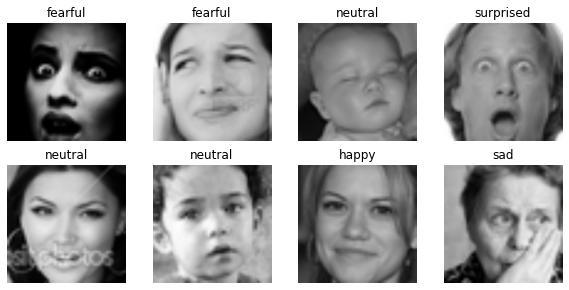

In [77]:
# Show some images from the dataset
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## **Data Augmentation Layers**

In [78]:
from keras import layers
data_augmentation = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(160,160,3)),
        keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

preprocessing_layer = keras.applications.vgg16.preprocess_input

print("Augmentation & Preprocessing layers created.")

Augmentation & Preprocessing layers created.


In [79]:
data_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 160, 160, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


### Plot some augmented images

In [80]:
'''for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')'''

"for image, _ in train_dataset.take(1):\n  plt.figure(figsize=(10,10))\n  first_image = image[0]\n  for i in range(9):\n    ax = plt.subplot(3,3, i+1)\n    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n    plt.imshow(augmented_image[0]/255)\n    plt.axis('off')"

## ***MobileNetV2*** Base Model

In [81]:
base_model = keras.applications.VGG16(input_shape=(160,160,3),
                                            include_top=False,
                                            weights='imagenet')

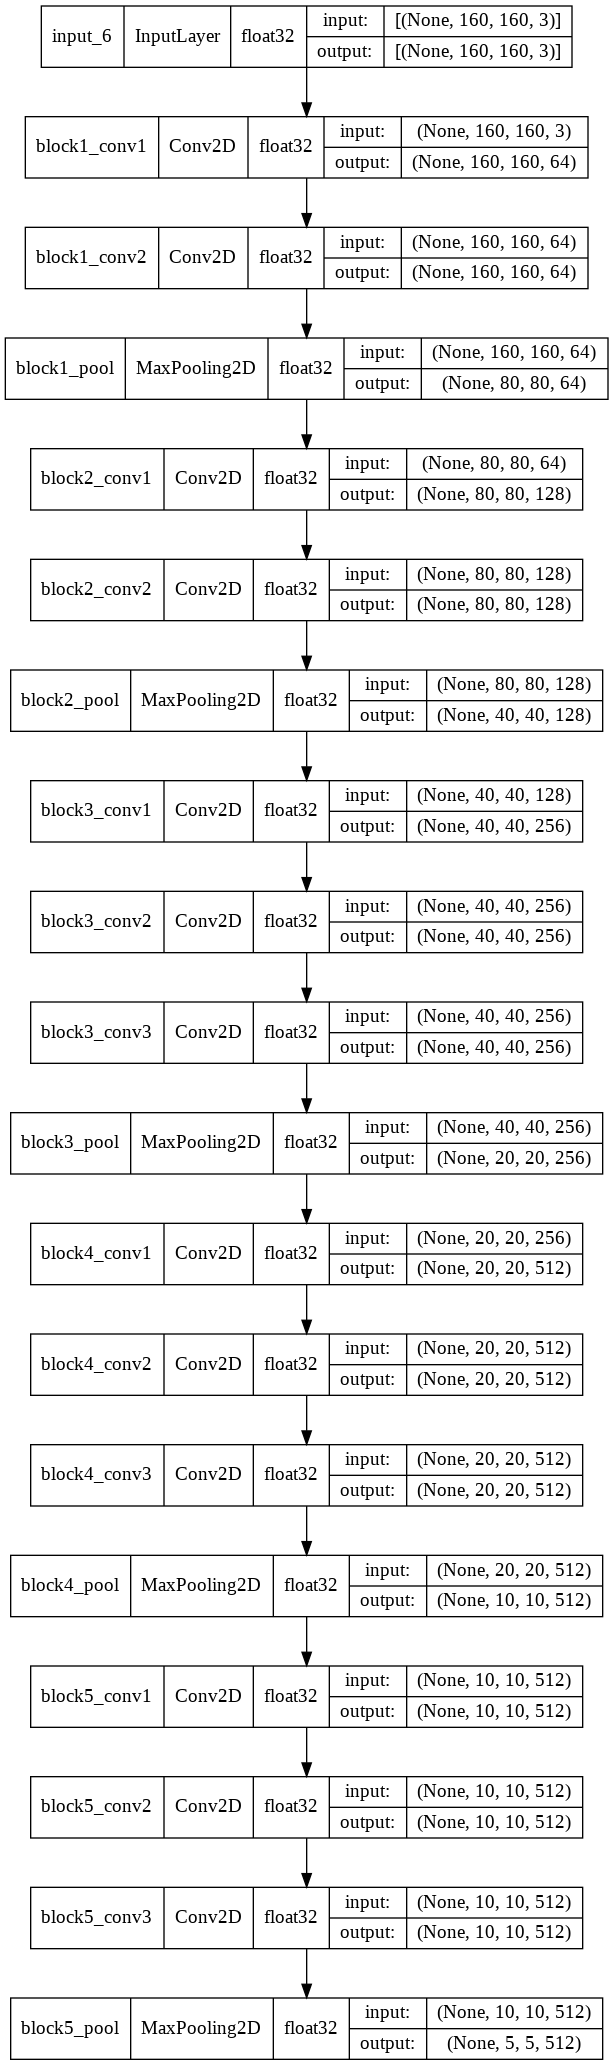

In [82]:
keras.utils.plot_model(base_model, show_dtype=True, show_shapes=True)

In [83]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

## Model creation

In [84]:
# Freeze all layers 
base_model.trainable = False

# Model creation - Functional API in Keras
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocessing_layer(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(7)(x)

model = keras.Model(inputs,outputs)

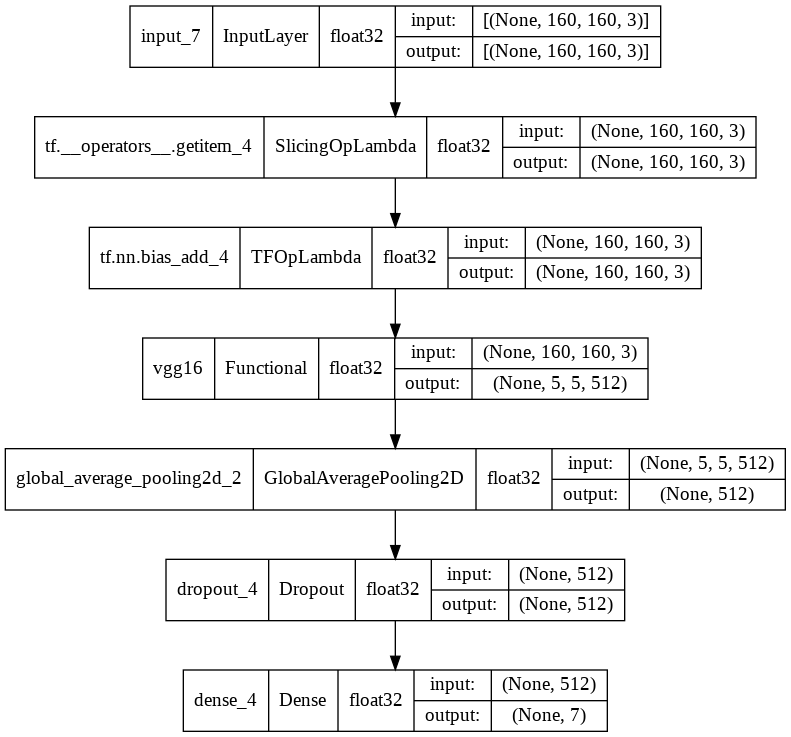

In [85]:
keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

In [86]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

## Initial Training of model




In [87]:
epochs = 5

loss_init, accuracy_init = model.evaluate(validation_dataset)

57/57 [==============================] - 28s 478ms/step - loss: 6.3078 - accuracy: 0.1188


In [88]:
history_init = model.fit(train_dataset,
                         epochs=epochs, 
                         validation_data=validation_dataset)

Epoch 1/5
225/225 [==============================] - 139s 611ms/step - loss: 3.7901 - accuracy: 0.2560 - val_loss: 1.7116 - val_accuracy: 0.3872
Epoch 2/5
225/225 [==============================] - 138s 612ms/step - loss: 1.8626 - accuracy: 0.3518 - val_loss: 1.5130 - val_accuracy: 0.4295
Epoch 3/5
225/225 [==============================] - 138s 610ms/step - loss: 1.6501 - accuracy: 0.3844 - val_loss: 1.5220 - val_accuracy: 0.4263
Epoch 4/5
225/225 [==============================] - 138s 612ms/step - loss: 1.6229 - accuracy: 0.3833 - val_loss: 1.4951 - val_accuracy: 0.4283
Epoch 5/5
225/225 [==============================] - 138s 610ms/step - loss: 1.6120 - accuracy: 0.3838 - val_loss: 1.4889 - val_accuracy: 0.4363


## Fine Tuning - Model

In [89]:
base_model.trainable = True

print("Number of layers in base model - ",len(base_model.layers))

Number of layers in base model -  19


In [90]:
# Fine Tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the above mentioned layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile & Train the new model

In [91]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [92]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs 

early_stop_callback = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)

history = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch=history_init.epoch[-1],
                         validation_data = validation_dataset,
                         callbacks= [early_stop_callback])

Epoch 5/15
225/225 [==============================] - 138s 608ms/step - loss: 1.6152 - accuracy: 0.3839 - val_loss: 1.5175 - val_accuracy: 0.4266
Epoch 6/15
225/225 [==============================] - 138s 609ms/step - loss: 1.6058 - accuracy: 0.3887 - val_loss: 1.4809 - val_accuracy: 0.4464
Epoch 7/15
225/225 [==============================] - 137s 608ms/step - loss: 1.6091 - accuracy: 0.3840 - val_loss: 1.4811 - val_accuracy: 0.4465
Epoch 8/15
225/225 [==============================] - 137s 608ms/step - loss: 1.6005 - accuracy: 0.3925 - val_loss: 1.4892 - val_accuracy: 0.4452
Epoch 9/15
225/225 [==============================] - 137s 608ms/step - loss: 1.6003 - accuracy: 0.3906 - val_loss: 1.4865 - val_accuracy: 0.4331


Saving angry.jpg to angry.jpg


Final prediction: 
The image is most likely angry with the accuracy of 75.26025176048279


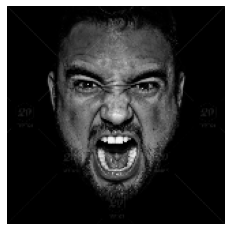

In [93]:
# Import the required libraries

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


for fn in uploaded.keys():

  path = '/content/' + fn
  # Load the image into the img variable
  img = image.load_img(path, target_size =(160,160))
  x = image.img_to_array(img) # Convert the image into array
  x = np.expand_dims(x, axis=0) # Expand the images as if they were many images

  images = np.vstack([x]) # Important
  classes = model.predict(images, batch_size=10)  # Gives the predictions for each classes like: [classes[0]: ([ 3.729408   -0.32879975  0.60124546 -3.0891216   0.56141305])]
  score = tf.nn.softmax(classes[0]) #Put the predictions into a softmax layer to get a [score: (tf.tensor)]

  name = class_names[np.argmax(score)]  
  accuracy = 100 * np.max(score) # Accuracy percentage
  
  plt.imshow(img)
  plt.axis("off")
  print("\n\nFinal prediction: ")
  print("The image is most likely "+ name +" with the accuracy of " + str(accuracy) )

In [95]:
class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']